In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#---------------------------
#ordenacao de informacoes em backend: tensorflow ou theano
#representa o "image data format"
#ambos possuem as mesmas informacoes, mas os parametros sao passados em posicoes diferentes
#TF:(808L,128L,128L,3L) : (num_samples, num_rows, num_columns, num_channels)
#TH:(808L,3L,128L,128L) : (num_samples, num_channels, num_rows, num_columns)
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

#%%
# Saving and loading model and weights
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


In [2]:
PATH = os.getcwd()

# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

img_rows=128
img_cols=128
num_channel=1 
num_epoch=8

img_data_list=[]

#---------------------------
#diretorio onde estao todas as imagens
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
    #Imagens por classes
    print (len(img_data_list), " imgs\n")


img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255

#---------------------------
if num_channel==1:
    if K.image_dim_ordering()=='th':
        img_data= np.expand_dims(img_data, axis=1) 
        print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=4) 
        print (img_data.shape)
#se for colorida a imagem
else:
    if K.image_dim_ordering()=='th':
        img_data=np.rollaxis(img_data,3,1)
        print (img_data.shape)

Loaded the images of dataset-Percurso2
632  imgs

Loaded the images of dataset-Percurso4
1212  imgs

Loaded the images of dataset-Percurso3
1585  imgs

Loaded the images of dataset-Percurso1
2247  imgs

(2247, 1, 128, 128)


In [3]:
#%%
USE_SKLEARN_PREPROCESSING=False

if USE_SKLEARN_PREPROCESSING:
    # using sklearn for preprocessing
    from sklearn import preprocessing

    def image_to_feature_vector(image, size=(128, 128)):
        # resize the image to a fixed size, then flatten the image into
        # a list of raw pixel intensities
        return cv2.resize(image, size).flatten()
    
    img_data_list=[]
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_flatten=image_to_feature_vector(input_img,(128,128))
            img_data_list.append(input_img_flatten)

    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    print (img_data.shape)
    img_data_scaled = preprocessing.scale(img_data)
    print (img_data_scaled.shape)

    print (np.mean(img_data_scaled))
    print (np.std(img_data_scaled))

    print (img_data_scaled.mean(axis=0))
    print (img_data_scaled.std(axis=0))

    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

if USE_SKLEARN_PREPROCESSING:
    img_data=img_data_scaled

In [4]:
# Define the number of classes
num_classes = 4

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

#Quantidade de imagens por classes
labels[0:632]=0
labels[633:1212]=1
labels[1213:1585]=2
labels[1586:]=3
  
names = ['percurso2','percurso4','percurso3','percurso1']
  
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# Defining the model
input_shape=img_data[0].shape
print("Input_shape: " , input_shape)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

Input_shape:  (1, 128, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 128)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 126, 126)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 126, 126)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 63, 63)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 63, 63)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 61, 61) 

True

In [5]:
# Training
hist = model.fit(X_train, y_train, batch_size=50, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test))

Train on 1797 samples, validate on 450 samples
Epoch 1/8
1797/1797 [==============================] - 441s 245ms/step - loss: 1.4791 - acc: 0.3350 - val_loss: 1.1930 - val_acc: 0.6378
Epoch 2/8
1797/1797 [==============================] - 440s 245ms/step - loss: 1.0718 - acc: 0.4396 - val_loss: 0.9994 - val_acc: 0.6533
Epoch 3/8
1797/1797 [==============================] - 430s 239ms/step - loss: 0.8769 - acc: 0.5993 - val_loss: 0.3725 - val_acc: 0.8889
Epoch 4/8
1797/1797 [==============================] - 429s 239ms/step - loss: 0.6976 - acc: 0.7807 - val_loss: 0.2096 - val_acc: 0.8911
Epoch 5/8
1797/1797 [==============================] - 574s 319ms/step - loss: 0.1756 - acc: 0.9521 - val_loss: 0.0943 - val_acc: 0.9644
Epoch 6/8
1797/1797 [==============================] - 531s 296ms/step - loss: 0.0995 - acc: 0.9727 - val_loss: 0.0192 - val_acc: 0.9978
Epoch 7/8
1797/1797 [==============================] - 527s 293ms/step - loss: 0.0645 - acc: 0.9822 - val_loss: 0.1272 - val_acc: 0

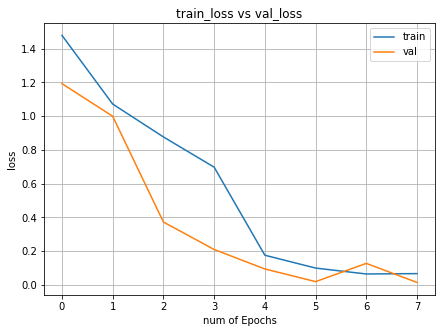

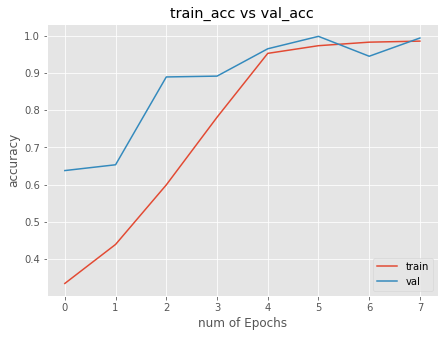

In [6]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['ggplot'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['ggplot'])

In [10]:
# Evaluating the model
score = model.evaluate(X_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

#test_image = X_test[0:1]
#print (test_image.shape)

#print(model.predict(test_image))
#print(model.predict_classes(test_image))
#print(y_test[0:1])

450/450 [==============================] - 50s 111ms/step
Test Loss: 0.014294314965227387
Test accuracy: 0.9933333333333333


In [13]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class 0(percurso2)', 'class 1(percurso4)', 'class 2(percurso3)','class 3(percurso4)']

print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[9.9999869e-01 1.3231981e-06 3.3720235e-09 4.4751540e-09]
 [8.3845458e-05 2.7682040e-07 9.9991274e-01 3.1317122e-06]
 [9.9950898e-01 4.3842774e-05 5.0314211e-06 4.4217514e-04]
 ...
 [5.5686887e-03 9.8964369e-01 3.8307726e-07 4.7871238e-03]
 [3.8963303e-06 3.3352407e-07 9.9999571e-01 7.3305591e-11]
 [6.6332636e-06 6.7228342e-07 9.9996626e-01 2.6401043e-05]]
[0 2 0 3 1 0 3 1 1 0 2 0 0 3 1 3 1 1 3 0 1 3 0 0 0 1 1 3 3 0 0 0 1 0 3 1 0
 0 2 1 1 3 1 0 1 1 1 3 2 1 3 1 0 2 1 2 3 0 2 3 0 3 1 3 3 1 0 1 2 3 3 0 3 2
 3 1 1 1 3 0 3 1 0 1 0 1 0 1 3 2 0 1 3 0 1 1 1 1 2 3 2 3 2 3 0 2 3 3 0 3 1
 1 3 0 3 3 3 3 0 1 1 3 2 1 0 0 1 3 1 3 3 0 3 3 3 0 1 3 0 3 2 0 3 1 1 1 0 1
 2 3 0 3 0 2 1 3 1 3 3 1 3 1 3 2 3 0 3 2 3 1 0 1 0 2 3 3 3 1 0 3 3 3 2 3 0
 3 0 2 3 3 0 2 1 3 3 0 3 2 3 0 2 0 0 0 1 3 0 3 0 1 0 1 1 1 0 3 3 2 3 1 1 1
 3 2 3 2 2 0 1 1 1 2 1 1 0 3 0 0 1 0 3 1 2 3 0 1 3 0 0 0 0 3 2 1 1 0 2 0 0
 2 1 1 3 2 0 0 1 1 3 1 1 0 2 1 0 1 3 3 1 3 3 3 3 0 2 0 1 1 1 2 2 2 2 3 2 0
 0 3 2 3 0 1 1 0 1 2 1 0 1 0 0 2 1 2 3 3

In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
model.save('model.hdf5')

Saved model to disk
